## Pairs Trading Strategies Using Python Linear Regression



## Pairs Trading

Pairs trading is a form of *mean-reversion* that has a distinct advantage of always being hedged against market movements. It is generally a high alpha strategy when backed up by some rigorous statistics. The stratey is based on mathematical analysis.

The prinicple is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.





In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

### Data Science in Trading

Before we begin, I’ll first define a function that makes it easy to find cointegrated security pairs 

In [14]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [77]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 1, 1)

tickers = ['^DJT','^CLLR','^PUTR','^DJA','^BXRC','^DJT','^CEX','^NYA']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%%**********************]  7 of 7 completed


,^BXRC,^CEX,^CLLR,^DJA,^DJT,^NYA,^PUTR
Date,,,,,,,
2017-12-22,230.460007,631.859985,239.750000,8326.860352,10674.969727,12797.440430,384.619995
2017-12-26,230.500000,629.270020,239.960007,8318.080078,10672.660156,12808.900391,385.200012
2017-12-27,230.669998,630.159973,240.119995,8334.559570,10697.209961,12821.990234,385.119995
2017-12-28,231.410004,632.260010,240.949997,8344.509766,10660.110352,12853.089844,385.679993
2017-12-29,230.070007,630.080017,239.460007,8310.349609,10612.290039,12808.839844,384.660004


[('^CEX', '^NYA')]


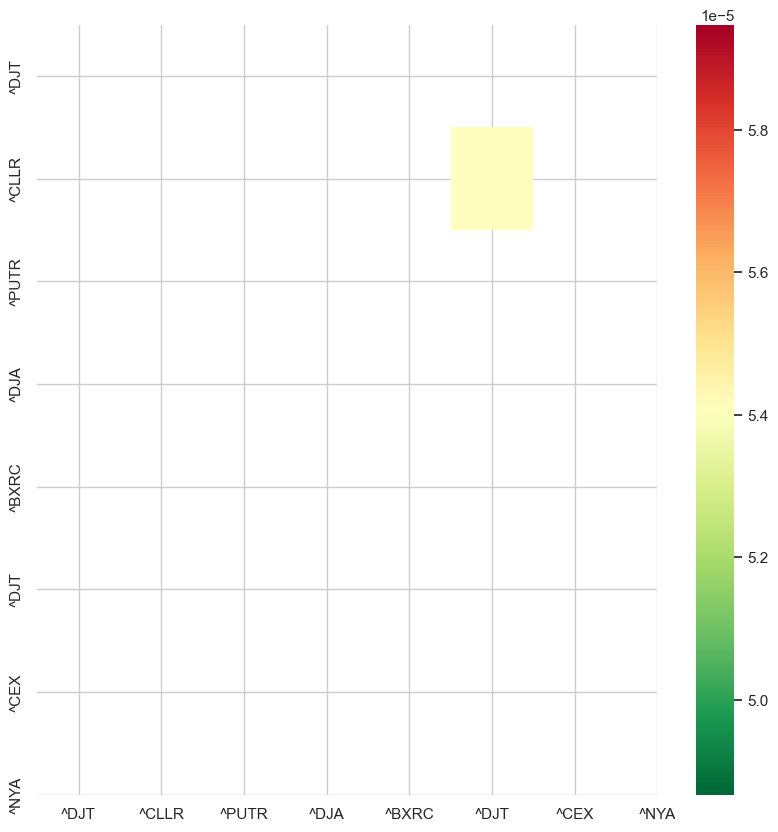

In [78]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [31]:
S1 = df['^CEX']
S2 = df['^NYA']

score, pvalue, _ = coint(S1, S2)
pvalue

5.407142129798487e-05

#### Calculating the Spread

Now we can plot the spread of the two time series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities, as mentioned with the Engle-Granger method before.

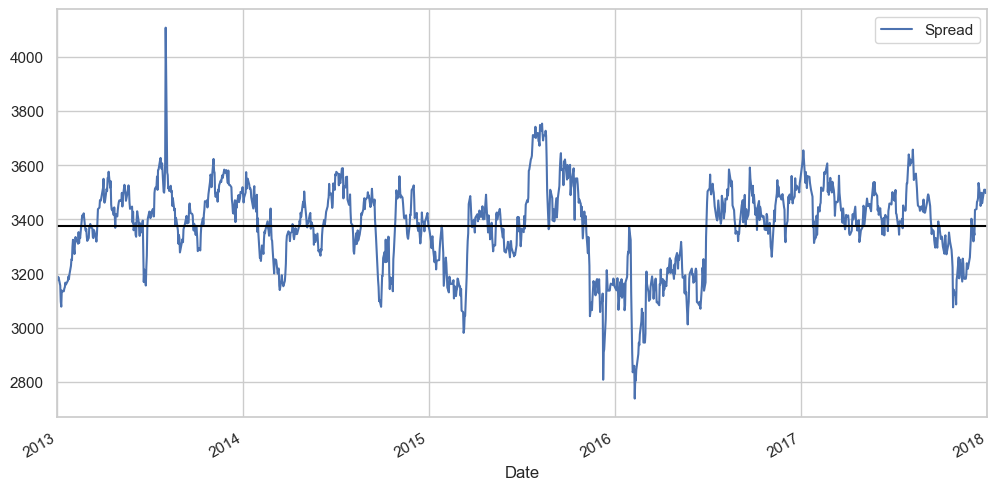

In [33]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['^CEX']
b = results.params['^CEX']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

Alternatively, we can examine the ration between the two time series

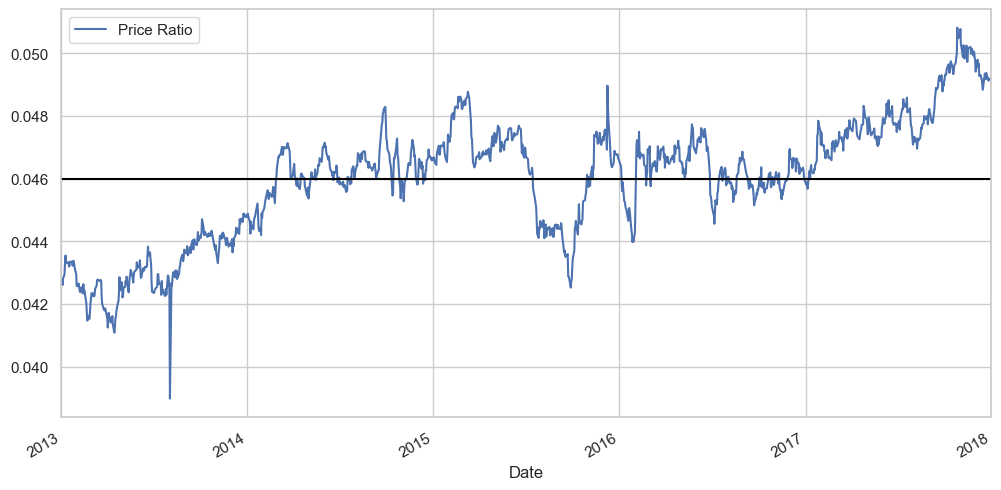

In [34]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

Regardless of whether or not we use the spread approach or the ratio approach, we can see that our first plot pair ADBE/SYMC tends to move around the mean. We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

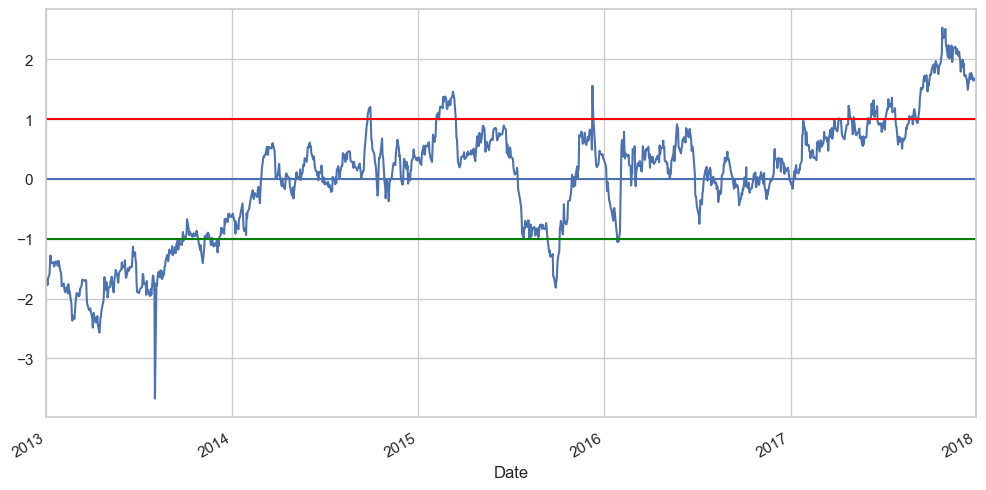

In [35]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

### Trading Signals

When conducting any type of trading strategy, it's always important to clearly define and delineate at what point you will actually do a trade. As in, what is the best indicator that I need to buy or sell a particular stock? 

#### Setup rules

We're going to use the ratio time series that we've created to see if it tells us whether to buy or sell a particular moment in time. We'll start off by creating a prediction variable $Y$. If the ratio is positive, it will signal a "buy," otherwise, it will signal a sell. The prediction model is as follows:

$$Y_{t} = sign(Ratio_{t+1}-Ratio_{t}) $$

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.

#### Train Test Split

When training and testing a model, it's common to have splits of 70/30 or 80/20. We only used a time series of 252 points (which is the amount of trading days in a year). Before training and splitting the data, we will add more data points in each time series.

In [37]:
ratios = df['^CEX'] / df['^NYA'] 
print(len(ratios) * .70 ) 

881.3


In [38]:
train = ratios[:881]
test = ratios[881:]

#### Feature Engineering

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z score

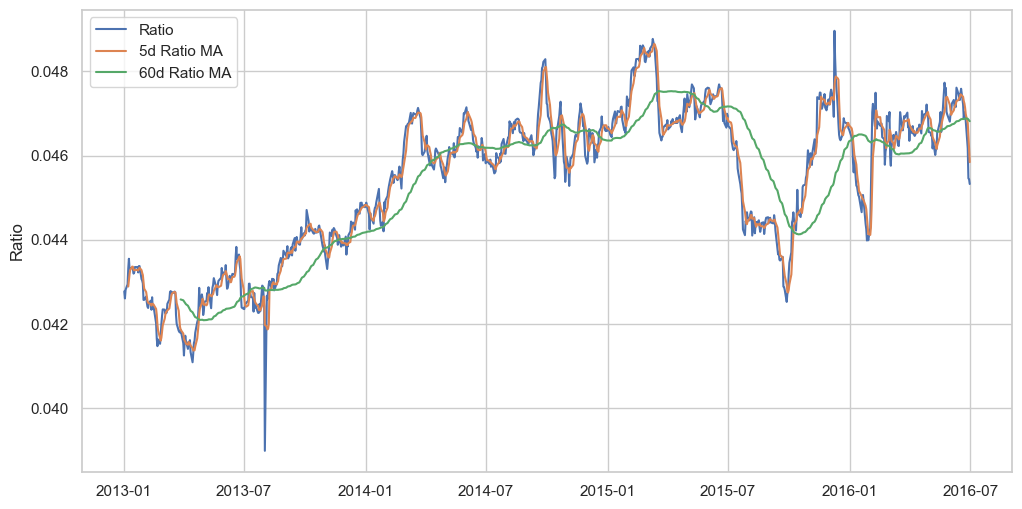

In [39]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

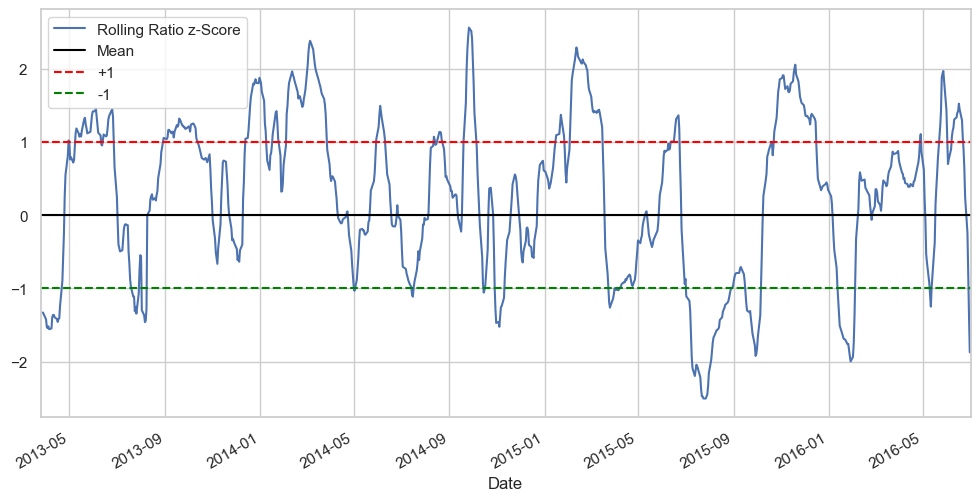

In [40]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

#### Creating a Model

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

* Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
* Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

#### Training Optimizing

We can use our model on actual data

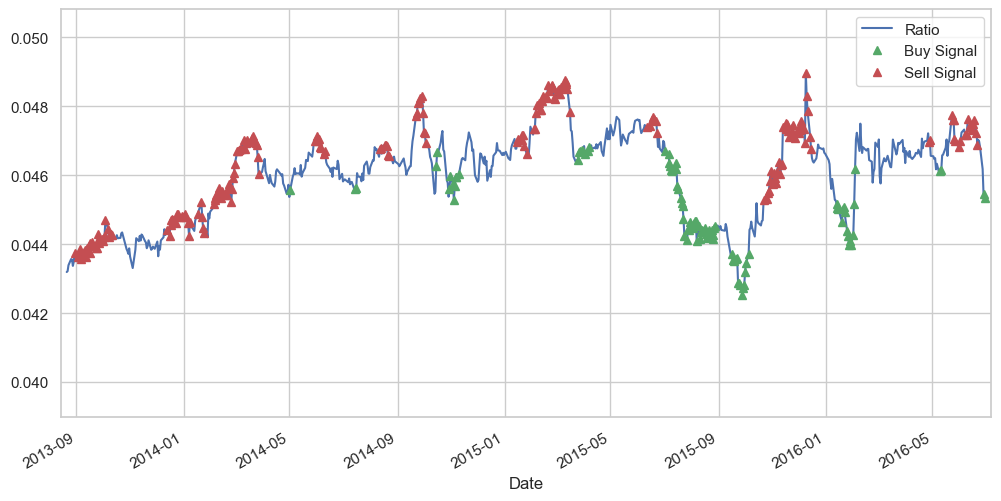

In [41]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

In [72]:
df['^CEX'],df['^NYA']

(Date
 2013-01-02    369.220001
 2013-01-03    366.739990
 2013-01-04    371.070007
 2013-01-07    370.890015
 2013-01-08    372.679993
                  ...    
 2017-12-22    631.859985
 2017-12-26    629.270020
 2017-12-27    630.159973
 2017-12-28    632.260010
 2017-12-29    630.080017
 Name: ^CEX, Length: 1259, dtype: float64,
 Date
 2013-01-02     8632.009766
 2013-01-03     8607.790039
 2013-01-04     8667.679688
 2013-01-07     8636.910156
 2013-01-08     8604.379883
                   ...     
 2017-12-22    12797.440430
 2017-12-26    12808.900391
 2017-12-27    12821.990234
 2017-12-28    12853.089844
 2017-12-29    12808.839844
 Name: ^NYA, Length: 1259, dtype: float64)

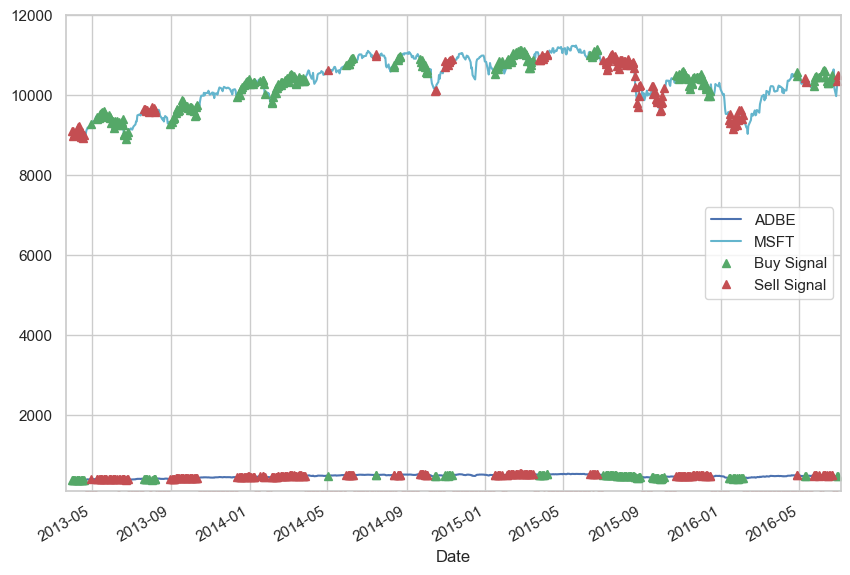

In [76]:
plt.figure(figsize=(10,7))
S1 = df['^CEX'].iloc[:881]
S2 = df['^NYA'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(100,12000)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

Now we can clearly see when we should buy or sell on the respective stocks.

Now, how much can we expect to make of this strategy?

In [45]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [48]:
trade(df['^CEX'].iloc[881:], df['^NYA'].iloc[881:], 60, 5)

384.1991996098289

Not a bad profit for a strategy that is made from stratch.

### Areas of Improvement and Further Steps

This is by no means a perfect strategy and the implementation of our strategy isn't the best. However, there are several things that can be improved upon.

#### 1. Using more securities and more varied time ranges

For the pairs trading strategy cointegration test, I only used a handful of stocks. Naturally (and in practice) it would be more effective to use clusters within an industry. I only use the time range of only 5 years, which may not be representative of stock market volatility.

#### 2. Dealing with overfitting

Anything related to data analysis and training models has much to do with the problem of overfitting. There are many different ways to deal with overfitting like validation, such as Kalman filters, and other statistical methods.

#### 3. Adjusting the trading signals

Our trading algorithm fails to account for stock prices that overlap and cross each other. Considering that the code only calls for a buy or sell given its ratio, it doesn't take into account which stock is actually higher or lower.

#### 4. More advanced methods

This is just the tip of the iceberg of what you can do with algorithmic pairs trading. It's simple because it only deals with moving averages and ratios. If you want to use more complicated statistics, feel free to do so. Other complex examples include subjects such as the Hurst exponent, half-life mean reversion, and Kalman Filters.